In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 49.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from torchvision.ops import box_convert
import torch
from PIL import Image, ImageDraw

In [4]:
DATA_DIR = '/content/drive/MyDrive/Virtual Mouse/TI1K-Dataset/'

with open("/content/drive/MyDrive/Virtual Mouse/TI1K-Dataset/annotation/label.txt", "r") as f:
  labels = f.read()

In [5]:
labels = labels.split("\n")

Train_labels = labels[:900]
Test_labels = labels[-100:]
len(Train_labels),len(Test_labels)

(900, 100)

In [6]:
annots = {}

for label in labels:
  lis = label.split()
  annots[lis[0]] = lis[1:]

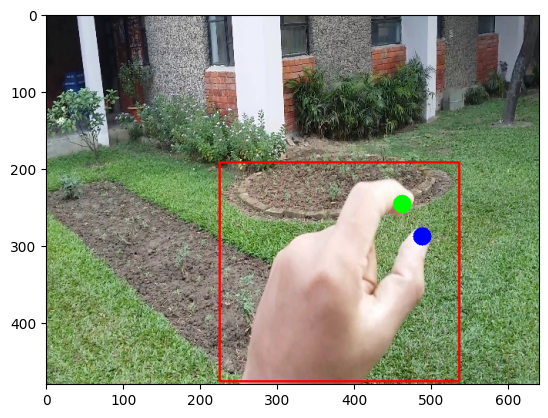

In [7]:
path = DATA_DIR + 'Data/images/train/TI1K_IMAGE_0038.jpg'
img_name = path.split('/')[-1]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
points = annots[img_name]
# print(points[0])
points = [float(p) for p in points]
h,w,_ = img.shape
pt1 = (int(points[0]*w), int(points[1]*h))
pt2 = (int(points[2]*w), int(points[3]*h))
img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2)
img = cv2.circle(img, (int(points[4]*w), int(points[5]*h)), 12, (0, 0, 255), -10) ##thumb
img = cv2.circle(img, (int(points[6]*w), int(points[7]*h)), 12, (0, 255, 0), -10) ##index
plt.imshow(img);

## Task 3: Generate Dataset

In [ ]:
def get_coords(labels):
  row = labels.split()
  points = row[1:]
  coords = [float(p) for p in points]

  xmin = coords[0]
  ymin = coords[1]
  xmax = coords[2]
  ymax = coords[3]
  tx = coords[4]
  ty = coords[5]
  ix = coords[6]
  iy = coords[7]

  bbox = torch.Tensor([xmin, ymin, xmax, ymax]) # Albumentation use this format
  bbox = box_convert(bbox, "xyxy", "cxcywh").tolist()
  bbox = [0 if val<0 else val for val in bbox]
  keypoints = [tx, ty, ix, iy]

  return bbox,keypoints

In [ ]:
path = '/content/drive/MyDrive/Virtual Mouse/TI1K-Dataset/Data/labels/train/'

for i in range(len(Train_labels)):
  labels = Train_labels[i]
  fn = path + labels.split()[0].split('.')[0]
  f = open(f"{fn}.txt", "w")

  bbox,kps = get_coords(labels)
  thumb,index = kps[:2],kps[-2:]

  bbox = [str(b) for b in bbox]
  thumb = [' ' + str(t) for t in thumb]
  index = [' ' + str(i) for i in index]

  thumb.append('2')
  index.append('2')

  box_str = '0 ' + " ".join(bbox)
  thumb_str = " ".join(thumb)
  index_str =" ".join(index)

  f.write(box_str)
  f.write(thumb_str)
  f.write(index_str)

  f.close()

In [ ]:
path = '/content/drive/MyDrive/Virtual Mouse/TI1K-Dataset/Data/labels/val/'

for i in range(len(Test_labels)):
  labels = Test_labels[i]
  fn = path + labels.split()[0].split('.')[0]
  f = open(f"{fn}.txt", "w")

  bbox,kps = get_coords(labels)
  thumb,index = kps[:2],kps[-2:]

  bbox = [str(b) for b in bbox]
  thumb = [' ' + str(t) for t in thumb]
  index = [' ' + str(i) for i in index]

  thumb.append('2')
  index.append('2')

  box_str = '0 ' + " ".join(bbox)
  thumb_str = " ".join(thumb)
  index_str =" ".join(index)

  f.write(box_str)
  f.write(thumb_str)
  f.write(index_str)

  f.close()

## Task: Model Training

In [8]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8x-pose.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/content/drive/MyDrive/Virtual Mouse/TI1K-Dataset/config.yaml", epochs=100, imgsz=224)

100%|██████████| 133M/133M [00:04<00:00, 33.9MB/s]


Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8x-pose.pt, data=/content/drive/MyDrive/Virtual Mouse/TI1K-Dataset/config.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

100%|██████████| 755k/755k [00:00<00:00, 107MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[2, 3]

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  

100%|██████████| 6.25M/6.25M [00:00<00:00, 18.3MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/.shortcut-targets-by-id/15Jw2jhq_oz2q20KU2qbLFSjxjxjLWd59/Virtual Mouse/TI1K-Dataset/Data/labels/train.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/.shortcut-targets-by-id/15Jw2jhq_oz2q20KU2qbLFSjxjxjLWd59/Virtual Mouse/TI1K-Dataset/Data/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 103 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/pose/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.75G      1.554     0.3421     0.3807      1.064       1.57          8        224: 100%|██████████| 57/57 [06:28<00:00,  6.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        100        100     0.0186       0.73     0.0165    0.00388     0.0169       0.66      0.016    0.00548



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.15G      1.399     0.1425     0.2477     0.9155      1.442         13        224: 100%|██████████| 57/57 [00:16<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        100        100      0.751      0.421      0.435      0.198      0.768      0.431      0.469      0.441



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.12G      1.421     0.1441     0.2027     0.9212      1.443         10        224: 100%|██████████| 57/57 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        100        100      0.025       0.68     0.0239    0.00969     0.0415       0.98     0.0449     0.0356



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.14G       1.34     0.1068     0.1906     0.8327      1.428         13        224: 100%|██████████| 57/57 [00:17<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        100        100      0.901       0.97      0.968      0.652      0.901       0.97      0.969      0.903



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.15G      1.287    0.09485     0.1598     0.7783       1.38         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        100        100      0.841       0.97      0.976       0.62      0.841       0.97      0.976      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.15G      1.253    0.09305      0.163     0.7713      1.366          6        224: 100%|██████████| 57/57 [00:17<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        100        100      0.998          1      0.995      0.665      0.998          1      0.995      0.994



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.13G      1.229    0.09062     0.1649      0.741      1.349          7        224: 100%|██████████| 57/57 [00:16<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        100        100       0.99          1      0.995      0.722       0.99          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.14G      1.194    0.07041     0.1449     0.7322      1.354         14        224: 100%|██████████| 57/57 [00:16<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        100        100      0.985          1      0.988       0.66      0.985          1      0.995      0.993



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.14G      1.187    0.06821     0.1268      0.704      1.332         11        224: 100%|██████████| 57/57 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        100        100      0.994          1      0.995      0.686      0.994          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.15G      1.163    0.06184     0.1398     0.6721      1.314          8        224: 100%|██████████| 57/57 [00:17<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        100        100      0.264          1      0.267      0.186      0.264          1      0.267      0.267



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.12G      1.128    0.05386     0.1123     0.6515       1.29          8        224: 100%|██████████| 57/57 [00:20<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        100        100      0.999          1      0.995      0.718      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.14G      1.118    0.05278     0.1168     0.6427      1.276         10        224: 100%|██████████| 57/57 [00:17<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all        100        100      0.998          1      0.995      0.738      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.15G      1.136    0.04814     0.1014     0.6256        1.3         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        100        100      0.998          1      0.995      0.739      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.15G      1.115    0.05522     0.1222     0.6348      1.278          9        224: 100%|██████████| 57/57 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        100        100      0.998          1      0.995      0.747      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.13G      1.112    0.04138     0.1127     0.6323      1.288          8        224: 100%|██████████| 57/57 [00:17<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        100        100      0.999          1      0.995       0.72      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.13G      1.086    0.04245     0.1011     0.6162      1.267         13        224: 100%|██████████| 57/57 [00:16<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        100        100      0.999          1      0.995      0.709      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.14G      1.075    0.04127    0.09811     0.5969       1.26         13        224: 100%|██████████| 57/57 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        100        100      0.999          1      0.995       0.72      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.15G       1.07    0.04168    0.08936     0.5914      1.262          9        224: 100%|██████████| 57/57 [00:17<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        100        100      0.999          1      0.995      0.714      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.12G      1.058    0.04021    0.09301       0.59      1.251         10        224: 100%|██████████| 57/57 [00:17<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        100        100      0.999          1      0.995      0.734      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.14G      1.032    0.03038     0.0978     0.5681      1.238          6        224: 100%|██████████| 57/57 [00:16<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        100        100      0.999          1      0.995      0.743      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.15G      1.072    0.04043     0.1075     0.5992      1.278         14        224: 100%|██████████| 57/57 [00:16<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        100        100      0.999          1      0.995      0.753      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.14G      1.063    0.03559    0.09573     0.5708      1.263         11        224: 100%|██████████| 57/57 [00:17<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        100        100      0.998          1      0.995      0.679      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.13G       1.07    0.03615    0.09807     0.5872      1.267          8        224: 100%|██████████| 57/57 [00:16<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        100        100      0.999          1      0.995      0.754      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.14G      1.036     0.0366    0.08396     0.5613      1.235         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        100        100      0.999          1      0.995      0.747      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.15G      1.043    0.03473    0.09129      0.557      1.239         10        224: 100%|██████████| 57/57 [00:20<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        100        100      0.999          1      0.995      0.733      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.14G      1.003    0.03215    0.08632      0.543      1.232         11        224: 100%|██████████| 57/57 [00:17<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        100        100      0.999          1      0.995      0.747      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.13G      1.025    0.03095    0.08085     0.5485      1.238          8        224: 100%|██████████| 57/57 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        100        100      0.999          1      0.995      0.766      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.14G      1.022    0.02874    0.07528     0.5481       1.24          6        224: 100%|██████████| 57/57 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        100        100      0.999          1      0.995       0.77      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.15G      1.006    0.02439    0.08299     0.5296      1.229          9        224: 100%|██████████| 57/57 [00:17<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        100        100      0.999          1      0.995      0.764      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.14G      1.026    0.02575    0.07109     0.5256      1.235          9        224: 100%|██████████| 57/57 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        100        100      0.999          1      0.995      0.738      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.13G     0.9959    0.03043    0.07502     0.5312      1.211          9        224: 100%|██████████| 57/57 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        100        100      0.999          1      0.995      0.725      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.15G     0.9984    0.03048    0.08863      0.531      1.215          9        224: 100%|██████████| 57/57 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        100        100      0.999          1      0.995      0.748      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.14G      1.005    0.03302    0.07243     0.5196       1.22         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        100        100      0.999          1      0.995      0.726      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.14G     0.9954    0.02649    0.08115     0.5325      1.225         12        224: 100%|██████████| 57/57 [00:16<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        100        100      0.999          1      0.995      0.732      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.13G     0.9933     0.0287    0.08438     0.5295      1.213         10        224: 100%|██████████| 57/57 [00:17<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        100        100      0.999          1      0.995      0.728      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.14G     0.9919    0.02628    0.07787     0.5127      1.202         11        224: 100%|██████████| 57/57 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        100        100      0.999          1      0.995      0.747      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.14G     0.9748    0.02867    0.06983     0.5036      1.197         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        100        100      0.999          1      0.995      0.735      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.14G      0.967    0.02767    0.07706     0.4999      1.204          7        224: 100%|██████████| 57/57 [00:16<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        100        100      0.999          1      0.995      0.774      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.13G     0.9636    0.02701    0.07981      0.498      1.193         14        224: 100%|██████████| 57/57 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        100        100      0.999          1      0.995      0.718      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.14G     0.9584    0.02897    0.07693     0.4991      1.193         11        224: 100%|██████████| 57/57 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all        100        100      0.999          1      0.995      0.774      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.14G     0.9674    0.02208    0.07649     0.5013       1.21          8        224: 100%|██████████| 57/57 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        100        100      0.999          1      0.995      0.748      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.15G     0.9552    0.02296    0.05415     0.4841      1.198         11        224: 100%|██████████| 57/57 [00:17<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        100        100      0.999          1      0.995      0.762      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.13G     0.9633    0.02068    0.05849     0.4871      1.212          8        224: 100%|██████████| 57/57 [00:17<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        100        100      0.999          1      0.995      0.782      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.14G      0.945    0.02074    0.06518     0.4801      1.191          5        224: 100%|██████████| 57/57 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        100        100      0.999          1      0.995      0.776      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.14G     0.9484     0.0213    0.06648     0.4899      1.187          7        224: 100%|██████████| 57/57 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all        100        100      0.999          1      0.995      0.766      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.15G     0.9421    0.02338     0.0559     0.4813      1.188         11        224: 100%|██████████| 57/57 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        100        100      0.999          1      0.995      0.771      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.13G     0.9457    0.02136    0.06396     0.4791      1.191         11        224: 100%|██████████| 57/57 [00:16<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        100        100      0.999          1      0.995      0.722      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.14G      0.954    0.02035     0.0622     0.4758      1.201         11        224: 100%|██████████| 57/57 [00:17<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        100        100      0.999          1      0.995      0.767      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.14G     0.9643    0.02137    0.06482      0.479      1.195          9        224: 100%|██████████| 57/57 [00:17<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        100        100      0.999          1      0.995      0.741      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.15G     0.9184    0.01838     0.0671     0.4667      1.174          9        224: 100%|██████████| 57/57 [00:17<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        100        100      0.999          1      0.995      0.773      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.13G     0.9235    0.01669    0.05311      0.459      1.174         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        100        100      0.999          1      0.995      0.748      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.14G     0.9322    0.01598    0.04848     0.4647      1.179          8        224: 100%|██████████| 57/57 [00:17<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        100        100      0.999          1      0.995      0.771      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.13G     0.9372     0.0171     0.0537     0.4674      1.178          8        224: 100%|██████████| 57/57 [00:16<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        100        100      0.999          1      0.995      0.753      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.14G      0.932    0.01979    0.05216     0.4688      1.171         14        224: 100%|██████████| 57/57 [00:17<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        100        100      0.999          1      0.995       0.78      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.13G     0.9117    0.01868    0.05489     0.4629      1.178         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all        100        100      0.999          1      0.995      0.745      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.14G     0.9267    0.02057    0.05335     0.4608      1.179         14        224: 100%|██████████| 57/57 [00:16<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        100        100      0.999          1      0.995      0.776      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.14G     0.9205     0.0163     0.0561     0.4584      1.172         11        224: 100%|██████████| 57/57 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        100        100      0.999          1      0.995       0.78      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.15G     0.9253    0.01643    0.04676     0.4626      1.184         12        224: 100%|██████████| 57/57 [00:17<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

                   all        100        100      0.999          1      0.995      0.774      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.13G     0.9122    0.01454    0.05015     0.4634      1.171         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        100        100      0.999          1      0.995      0.773      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.15G     0.9218     0.0161    0.05866      0.454      1.169          9        224: 100%|██████████| 57/57 [00:16<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        100        100      0.999          1      0.995      0.773      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.15G     0.9025    0.01542    0.05636     0.4515      1.163          8        224: 100%|██████████| 57/57 [00:16<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


                   all        100        100      0.999          1      0.995      0.775      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.15G      0.904    0.01552    0.05658     0.4512      1.174         10        224: 100%|██████████| 57/57 [00:17<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        100        100      0.999          1      0.995       0.76      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.13G     0.8922    0.01643    0.05406     0.4402      1.163          5        224: 100%|██████████| 57/57 [00:17<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all        100        100      0.999          1      0.995      0.753      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.14G     0.8926    0.01349    0.04885     0.4434      1.157         10        224: 100%|██████████| 57/57 [00:20<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        100        100      0.999          1      0.995      0.768      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.14G     0.8898    0.01441    0.03938     0.4344      1.156          9        224: 100%|██████████| 57/57 [00:16<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        100        100      0.999          1      0.995      0.771      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.15G     0.8714    0.01421    0.04794     0.4334      1.147          8        224: 100%|██████████| 57/57 [00:17<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        100        100      0.999          1      0.995      0.793      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.13G     0.8709    0.01461    0.05143     0.4312       1.15         12        224: 100%|██████████| 57/57 [00:17<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        100        100          1          1      0.995      0.786          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.14G     0.8927    0.01261    0.05129     0.4319      1.156         13        224: 100%|██████████| 57/57 [00:17<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        100        100      0.999          1      0.995      0.777      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.15G     0.8975    0.01215    0.04359     0.4465      1.152         13        224: 100%|██████████| 57/57 [00:16<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        100        100      0.999          1      0.995      0.776      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.15G     0.8794    0.01399    0.04769     0.4244       1.15         15        224: 100%|██████████| 57/57 [00:17<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        100        100      0.999          1      0.995      0.777      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.13G     0.8671    0.01323    0.04734     0.4241      1.154         11        224: 100%|██████████| 57/57 [00:17<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        100        100      0.999          1      0.995      0.785      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.14G     0.8775     0.0138    0.04625     0.4303      1.149          8        224: 100%|██████████| 57/57 [00:17<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        100        100      0.999          1      0.995      0.766      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.14G     0.8891    0.01286    0.04524     0.4235       1.15         13        224: 100%|██████████| 57/57 [00:16<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


                   all        100        100      0.999          1      0.995      0.767      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.15G     0.8701    0.01187    0.04452     0.4199       1.15          7        224: 100%|██████████| 57/57 [00:16<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        100        100      0.999          1      0.995      0.773      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.13G     0.8514    0.01185    0.04823     0.4104      1.134          5        224: 100%|██████████| 57/57 [00:17<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        100        100      0.999          1      0.995      0.748      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.14G     0.8567    0.01343    0.04868     0.4107      1.144         11        224: 100%|██████████| 57/57 [00:17<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        100        100      0.999          1      0.995      0.758      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.15G     0.8588    0.01163    0.04096     0.4095       1.14         11        224: 100%|██████████| 57/57 [00:17<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        100        100      0.999          1      0.995      0.751      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.13G      0.853    0.01221    0.04617      0.408      1.134          9        224: 100%|██████████| 57/57 [00:19<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        100        100      0.999          1      0.995      0.778      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.13G       0.86    0.01106    0.04742     0.4168      1.139          8        224: 100%|██████████| 57/57 [00:16<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        100        100      0.999          1      0.995      0.763      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.14G     0.8568    0.01037     0.0416     0.4067       1.13         13        224: 100%|██████████| 57/57 [00:16<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        100        100          1          1      0.995      0.775          1          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.15G     0.8403    0.01204    0.04263     0.4078       1.12         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        100        100      0.999          1      0.995       0.77      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.15G     0.8502    0.01147    0.04431     0.4061      1.132         15        224: 100%|██████████| 57/57 [00:17<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        100        100      0.999          1      0.995      0.782      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.13G     0.8346    0.01052    0.04125     0.3945      1.128         11        224: 100%|██████████| 57/57 [00:16<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        100        100      0.999          1      0.995      0.785      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.14G     0.8268    0.01145    0.03596     0.3898      1.126          5        224: 100%|██████████| 57/57 [00:17<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        100        100      0.999          1      0.995      0.782      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.15G     0.8483    0.01082    0.04302     0.4024      1.141         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        100        100      0.999          1      0.995      0.785      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.14G     0.8194   0.009863    0.03558     0.3839      1.126         13        224: 100%|██████████| 57/57 [00:16<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        100        100      0.999          1      0.995      0.774      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.13G     0.8309      0.011    0.03341     0.3943      1.129          9        224: 100%|██████████| 57/57 [00:17<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        100        100      0.999          1      0.995      0.773      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.13G     0.8329   0.009374    0.04428     0.3904      1.122         10        224: 100%|██████████| 57/57 [00:17<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        100        100      0.999          1      0.995      0.781      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.14G     0.8115   0.009847    0.03692     0.3832      1.114          7        224: 100%|██████████| 57/57 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        100        100      0.999          1      0.995      0.781      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.15G     0.8472       0.01    0.04003     0.3915      1.132         10        224: 100%|██████████| 57/57 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        100        100      0.999          1      0.995      0.777      0.999          1      0.995      0.995


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.13G      0.759   0.007301   0.002023     0.2847      1.081          4        224: 100%|██████████| 57/57 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        100        100      0.999          1      0.995      0.759      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.14G     0.7472   0.006963   0.001165     0.2773      1.066          4        224: 100%|██████████| 57/57 [00:19<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        100        100      0.999          1      0.995      0.766      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.15G     0.7494   0.006924  0.0008213     0.2799      1.069          4        224: 100%|██████████| 57/57 [00:16<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        100        100      0.999          1      0.995      0.765      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.14G     0.7467   0.006787  0.0005906     0.2743      1.073          4        224: 100%|██████████| 57/57 [00:15<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        100        100      0.999          1      0.995      0.764      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.13G     0.7366   0.006796  0.0005288     0.2741      1.061          4        224: 100%|██████████| 57/57 [00:16<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        100        100      0.999          1      0.995      0.768      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.14G     0.7399   0.006733    0.00133     0.2742      1.062          4        224: 100%|██████████| 57/57 [00:16<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        100        100      0.999          1      0.995      0.759      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.15G     0.7314   0.006343   0.003739     0.2708      1.073          4        224: 100%|██████████| 57/57 [00:16<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        100        100      0.999          1      0.995      0.766      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.14G     0.7202   0.006145  0.0009721     0.2671      1.057          4        224: 100%|██████████| 57/57 [00:16<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        100        100      0.999          1      0.995      0.763      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.12G     0.7334    0.00601  0.0004862     0.2722      1.056          4        224: 100%|██████████| 57/57 [00:18<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        100        100      0.999          1      0.995      0.771      0.999          1      0.995      0.995



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.14G      0.717   0.006066   0.000841     0.2644      1.058          4        224: 100%|██████████| 57/57 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all        100        100      0.999          1      0.995       0.77      0.999          1      0.995      0.995



100 epochs completed in 0.774 hours.
Optimizer stripped from runs/pose/train/weights/last.pt, 139.4MB
Optimizer stripped from runs/pose/train/weights/best.pt, 139.4MB

Validating runs/pose/train/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-pose summary (fused): 287 layers, 69,451,269 parameters, 0 gradients, 263.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


                   all        100        100      0.999          1      0.995      0.792      0.999          1      0.995      0.995
Speed: 0.3ms preprocess, 4.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/pose/train


In [9]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"

In [10]:
!cp -r "/content/runs" "/content/drive/MyDrive/Virtual Mouse"

In [11]:
tfliteyolo = YOLO("/content/drive/MyDrive/Virtual Mouse/runs/pose/train/weights/best.pt")
tfliteyolo.export(format="tflite")

Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLOv8x-pose summary (fused): 287 layers, 69,451,269 parameters, 0 gradients, 263.2 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/Virtual Mouse/runs/pose/train/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 11, 1029) (132.9 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 146.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 221.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

100%|██████████| 1.11M/1.11M [00:00<00:00, 140MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 44.59file/s]


ONNX: starting export with onnx 1.16.2 opset 19...


ONNX: slimming with onnxslim 0.1.34...
ONNX: export success ✅ 9.7s, saved as '/content/drive/MyDrive/Virtual Mouse/runs/pose/train/weights/best.onnx' (265.1 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 160.1s, saved as '/content/drive/MyDrive/Virtual Mouse/runs/pose/train/weights/best_saved_model' (662.8 MB)

TensorFlow Lite: starting export with tensorflow 2.17.0...
TensorFlow Lite: export success ✅ 0.0s, saved as '/content/drive/MyDrive/Virtual Mouse/runs/pose/train/weights/best_saved_model/best_float32.tflite' (265.1 MB)

Export complete (165.4s)
Results saved to /content/drive/.shortcut-targets-by-id/15Jw2jhq_oz2q20KU2qbLFSjxjxjLWd59/Virtual Mouse/runs/pose/train/weights
Predict:         yolo predict task=pose model=/content/drive/MyDrive/Virtual Mouse/runs/pose/train/weights/best_saved_model/best_float32.tflite imgsz=224  
Validate:        yolo val task=pose model=/content/drive/MyDrive/Virtual Mouse/runs/pose/tra

'/content/drive/MyDrive/Virtual Mouse/runs/pose/train/weights/best_saved_model/best_float32.tflite'